In [9]:
from sklearn.model_selection import train_test_split

from pstree.cluster_gp_sklearn import PSTreeRegressor, GPRegressor
from pstree.datasets.data_loader import *
from pstree.datasets.synthetic_datasets import * 
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import r2_score, root_mean_squared_error as rmse

from matplotlib import pyplot as plt

gen	time     	rmse	r2  	nodes	pop_nodes
0  	0.0856001	8.24	0.41	197  	22       
1  	0.692447 	9.63	0.2 	365  	44       
2  	0.863587 	9.42	0.23	339  	52       
3  	1.17234  	8.79	0.33	345  	54       
4  	1.34243  	8.73	0.34	327  	42       
5  	1.72925  	8.83	0.32	313  	52       
6  	2.11077  	9.14	0.28	361  	62       
7  	2.42019  	8.96	0.3 	393  	76       
8  	2.64947  	8.85	0.32	435  	82       
9  	2.8003   	9.04	0.29	483  	68       
10 	2.94037  	9.05	0.29	381  	70       
11 	3.07368  	8.99	0.3 	427  	82       
12 	3.21295  	9.06	0.29	457  	88       
13 	3.33989  	9.05	0.29	503  	92       
14 	3.47992  	8.9 	0.31	549  	98       
15 	3.62261  	8.99	0.3 	543  	88       
16 	3.7586   	8.94	0.31	543  	78       
17 	3.88826  	8.97	0.3 	451  	80       
18 	4.02777  	9.05	0.29	373  	70       
19 	4.17755  	8.85	0.32	409  	76       
20 	4.32647  	8.93	0.31	489  	100      
21 	4.46523  	8.97	0.3 	557  	104      
22 	4.61392  	8.99	0.3 	585  	108      
23 	4.74882  	8.99	0.3 	645  	116      


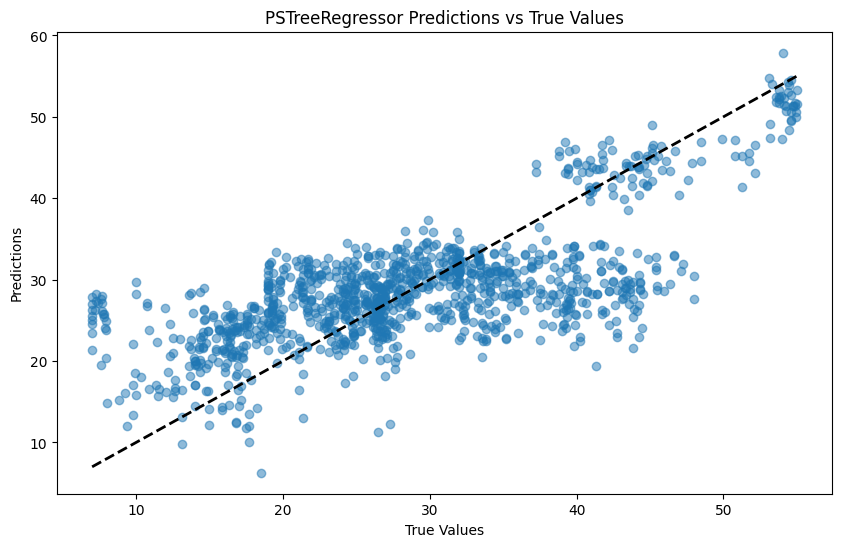

In [13]:
X,y = load_istanbul()
X,y = load_parkinson_updrs()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

r = PSTreeRegressor(regr_class=GPRegressor, 
                    tree_class=DecisionTreeRegressor,
                    height_limit=6, 
                    n_pop=10,  # 25
                    n_gen=40,  # 50 
                    max_depth=4, 
                    basic_primitive=True,
                    size_objective=True,
                    max_leaf_nodes=4,
                    constant_range=2,  # 2 
                    min_samples_leaf=50, 
                    random_seed=0, 
                    random_state=0,
                    normalize=False,
                    verbose=True,
                    soft_tree=False,
                    afp=False,
                    X_test=X_test,
                    y_test=y_test,
                    validation_selection=False,
)

r.fit(X_train, y_train)
print('R2: ', r2_score(y_test, r.predict(X_test)))
print('RMSE: ', rmse(y_test, r.predict(X_test)))

plt.figure(figsize=(10, 6))
plt.scatter(y_test, r.predict(X_test), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('PSTreeRegressor Predictions vs True Values')
plt.show()

In [ ]:
import time 
from tests.metrics_test import *
from tests.metrics_test import calc_scores_from_summary as calc_scores
from tests.misc_functions import * 
import pickle as pkl
from tests.experiments.PSTREE.config_ps3 import ps3_params, config
del train_test_split 
from tests.metrics_test import train_test_split



def ps3_test(best_params, 
               dataset, 
               split_id, 
               seed,
               **kwargs):
    
    dataset = dataset.copy()
    params = best_params.copy()

    mask = dataset.pop('mask', None) 
    bcv_rmse = params.pop('bcv_rmse')
    X_tr, y_tr = dataset['X_train'], dataset['y_train']
    X_te, y_te = dataset['X_test'], dataset['y_test']
    params['X_test'] = X_te
    params['y_test'] = y_te
    

    reg = PSTreeRegressor(
        **params,
        # test_data = (X_te, y_te),
        random_seed  = seed,
        random_state = seed,
    )
        
    t0 = time.time()
    reg.fit(X_tr, y_tr)
    
    elapsed         = time.time() - t0
    labels          = reg.predict_labels(X_tr)
    rmse_train      = rmse(reg.predict(X_tr), y_tr)
    rmse_test       = rmse(reg.predict(X_te), y_te)
    r2_train        = r_squared(y_tr, reg.predict(X_tr))
    r2_test         = r_squared(y_te, reg.predict(X_te))
    class_n         = len(np.unique(labels))
    overfit         = (100 * (rmse_train - rmse_test) / rmse_train)
    gen_gap         = 100 * abs(rmse_test - bcv_rmse) / bcv_rmse
    logs            = reg.regr.log_book 
    pop_stats       = []
    
    extra_records = {}
    if mask is not None:
        class_summary = get_classification_summary(
                X_data      = X_tr, 
                mask        = mask,
                spec_masks  = labels
                )
        
        acc, macro_f1, weighted_f1 = calc_scores(class_summary)   
        extra_records = {
            'acc'           : acc,
            'macro_f1'      : macro_f1,
            'weighted_f1'   : weighted_f1,
            'class_summary' : str(class_summary)
        }     
        
    records = {
        'dataset_name'          : best_params['dataset_name'],
        'split_id'              : split_id,
        'trial_id'              : seed,
        'seed'                  : seed,
        'rmse_train'            : rmse_train,
        'rmse_test'             : rmse_test,
        'r2_train'              : r2_train,
        'r2_test'               : r2_test,
        'nodes'                 : reg.regr.nodes_count,
        'classes_n'             : class_n,
        'overfit'               : overfit,
        'gen_gap'               : gen_gap,
        'time'                  : elapsed,
        **extra_records
    }

    return records, pop_stats, logs 

with open('checkpoint_params_split2_1.pkl', 'rb') as f:
    best_params = pkl.load(f)
    
best_params.update({'verbose': True})

dataset = load_synthetic3()
idx_train, idx_test = train_test_split(dataset[0], dataset[1], p_test=config['P_TEST'], seed=3, indices_only=True)
X_train, X_test = dataset[0][idx_train], dataset[0][idx_test]
y_train, y_test = dataset[1][idx_train], dataset[1][idx_test]
mask = [sbmask[idx_train] for sbmask in dataset[3]]

dataset = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'mask': mask
    }

rec, pops, logs = ps3_test(best_params, 
                        dataset, 
                        2, 
                        13,)    


gen	time     	rmse	r2  	nodes	pop_nodes
0  	0.0553122	0.45	0.99	463  	75       
1  	0.419585 	0.21	1   	1275 	119      
2  	0.598003 	0.26	1   	1669 	135      
3  	0.720355 	0.1 	1   	1779 	177      
4  	0.697659 	0.07	1   	2119 	201      
5  	0.846633 	0.05	1   	2211 	213      
6  	0.995339 	0.04	1   	2299 	225      
7  	1.11954  	0.05	1   	2421 	243      
8  	1.23843  	0.04	1   	2617 	243      
9  	1.35645  	0.04	1   	2627 	253      
10 	1.47823  	0.04	1   	2657 	269      
11 	1.57286  	0.04	1   	2783 	293      
12 	1.67476  	0.04	1   	2921 	287      
13 	1.78766  	0.03	1   	2863 	313      
14 	1.87957  	0.02	1   	2991 	313      
15 	1.97516  	0.01	1   	3159 	333      
16 	2.06804  	0.01	1   	3175 	339      
17 	2.1755   	1.33	0.91	3193 	323      
18 	2.29405  	0.03	1   	3057 	313      
19 	2.39556  	0.11	1   	3249 	327      
20 	2.49797  	0.07	1   	3005 	337      
21 	2.58291  	0.03	1   	3181 	361      
22 	2.66687  	0.01	1   	3535 	357      
23 	2.79064  	0.01	1   	3347 	347      


In [6]:
ps3_params['verbose'] = True 


ps3_params['height_limit'] = 5
ps3_params['max_leaf_nodes'] = 4
ps3_params['random_state'] = 13 
ps3_params['random_seed'] = 13
ps3_params['n_gen'] = 2

 
X,y,_,mask = load_synthetic3()
tr, te = train_test_split(X, y, p_test=0.25, seed=2, indices_only=True)
X_train, y_train = X[tr], y[tr]
X_test, y_test = X[te], y[te]
mask_train = [s[tr] for s in mask]

ps3_params['X_test'] = X_test
ps3_params['y_test'] = y_test


r = PSTreeRegressor(**ps3_params)
                    
r.fit(X_train, y_train)

gen	time     	rmse	r2  	nodes	pop_nodes
0  	0.0597413	0.43	0.99	463  	75       
1  	0.149894 	0.19	1   	1261 	127      
2  	0.256803 	0.14	1   	1779 	167      
FINAL	0.357381 	0.14	1   	1779 	167      


,regr_class,<class 'pstre....GPRegressor'>
,tree_class,<class 'sklea...eeClassifier'>
,min_samples_leaf,1
,max_depth,None
,max_leaf_nodes,4
,random_seed,13
,restricted_classification_tree,True
,basic_primitive,True
,soft_tree,False
,final_soft_tree,False
,adaptive_tree,True


rmse_train                      0.008784
rmse_test                       0.008185
r2_train                        0.999996
r2_test                         0.999997
nodes                               2842


In [7]:
from tests.misc_functions import get_classification_summary
from tests.metrics_test import calc_scores_from_summary as calc_scores

labels          = r.predict_labels(X_train)
class_n         = len(np.unique(labels))
class_summary = get_classification_summary(
        X_data      = X_train, 
        mask        = mask_train,
        spec_masks  = labels
        )

acc, macro_f1, weighted_f1 = calc_scores(class_summary)   
